# IMPORT LIBRARIES

In [1]:
import yfinance as yf
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tabulate import tabulate
import nltk
from math import sqrt

# Downloading, merging and preprocessing non financial dataset.

In [2]:
def download_data(ticker, start_date, end_date):
    try:
        df = yf.download(ticker, start=start_date, end=end_date)
        df = df['Close'].rename(ticker)
        return df
    except Exception as e:
        print(f"Error downloading data for {ticker}: {e}")
        return pd.Series(name=ticker)

end_date = datetime.datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.datetime.now() - datetime.timedelta(days=20*365)).strftime('%Y-%m-%d')

tickers = ['RELIANCE.NS', 'GOLDBEES.NS', 'IOC.NS', 'INR=X']

dataframes = [download_data(ticker, start_date, end_date) for ticker in tickers]

merged_data = pd.concat(dataframes, axis=1).dropna()
merged_data.columns = ['RELIANCE', 'GOLD', 'PETROL', 'CURRENCY']

merged_data.to_csv('merged_data.csv')

if merged_data.isna().any().any():
    print("Warning: NaN values present in the merged data.")
else:
    print("Data downloaded and merged successfully.")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Data downloaded and merged successfully.


In [3]:
data = pd.read_csv('merged_data.csv')
df = data

In [4]:
data

,Date,RELIANCE,GOLD,PETROL,CURRENCY
0,2009-01-02,294.049408,13.370000,35.908333,48.244999
1,2009-01-05,312.210327,13.155500,35.137501,48.229000
2,2009-01-06,313.364685,13.040000,36.229164,48.505001
3,2009-01-07,274.471252,13.215000,35.095833,48.550999
4,2009-01-09,263.613556,13.168900,36.241665,48.467999
...,...,...,...,...,...
3758,2024-04-18,2928.649902,61.959999,169.000000,83.595802
3759,2024-04-19,2940.250000,62.240002,166.649994,83.544998
3760,2024-04-22,2959.699951,61.740002,170.899994,83.385300
3761,2024-04-23,2918.649902,60.250000,168.100006,83.386200


In [5]:
data.dtypes

Date         object
RELIANCE    float64
GOLD        float64
PETROL      float64
CURRENCY    float64
dtype: object

In [6]:
def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year = year, month = month, day = day)
datetime_object = str_to_datetime('2020-01-01')
datetime_object

datetime.datetime(2020, 1, 1, 0, 0)

In [7]:
data['Date'] = data['Date'].apply(str_to_datetime)
data['Date']

0      2009-01-02
1      2009-01-05
2      2009-01-06
3      2009-01-07
4      2009-01-09
          ...    
3758   2024-04-18
3759   2024-04-19
3760   2024-04-22
3761   2024-04-23
3762   2024-04-24
Name: Date, Length: 3763, dtype: datetime64[ns]

In [8]:
data.index = data.pop('Date')
data

,RELIANCE,GOLD,PETROL,CURRENCY
Date,,,,
2009-01-02,294.049408,13.370000,35.908333,48.244999
2009-01-05,312.210327,13.155500,35.137501,48.229000
2009-01-06,313.364685,13.040000,36.229164,48.505001
2009-01-07,274.471252,13.215000,35.095833,48.550999
2009-01-09,263.613556,13.168900,36.241665,48.467999
...,...,...,...,...
2024-04-18,2928.649902,61.959999,169.000000,83.595802
2024-04-19,2940.250000,62.240002,166.649994,83.544998
2024-04-22,2959.699951,61.740002,170.899994,83.385300


In [9]:
data.shape

(3763, 4)

In [10]:
data.describe()

,RELIANCE,GOLD,PETROL,CURRENCY
count,3763.000000,3763.000000,3763.000000,3763.000000
mean,1007.048591,30.568802,73.558682,64.266259
std,773.922681,10.312356,29.722938,11.572400
min,246.309799,0.335500,32.058334,43.900002
25%,420.753052,24.791250,51.850000,54.487999
50%,494.562561,27.541000,66.500000,65.232399
75%,1671.298584,40.594999,89.800003,73.365501
max,3014.800049,62.240002,192.399994,85.194000


In [11]:
print(data.isnull().sum())

RELIANCE    0
GOLD        0
PETROL      0
CURRENCY    0
dtype: int64


In [12]:
data.dropna(inplace=True)

In [13]:
print(data.isnull().sum())

RELIANCE    0
GOLD        0
PETROL      0
CURRENCY    0
dtype: int64


In [14]:
data.shape

(3763, 4)

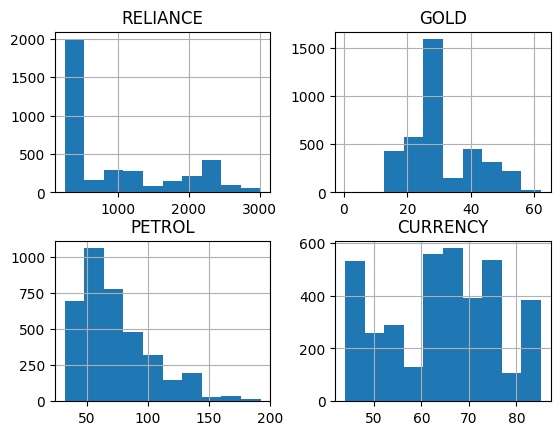

In [15]:
data.hist()
plt.show()

In [16]:
print(data.corr())

          RELIANCE      GOLD    PETROL  CURRENCY
RELIANCE  1.000000  0.905223  0.403255  0.816594
GOLD      0.905223  1.000000  0.332661  0.861789
PETROL    0.403255  0.332661  1.000000  0.501445
CURRENCY  0.816594  0.861789  0.501445  1.000000


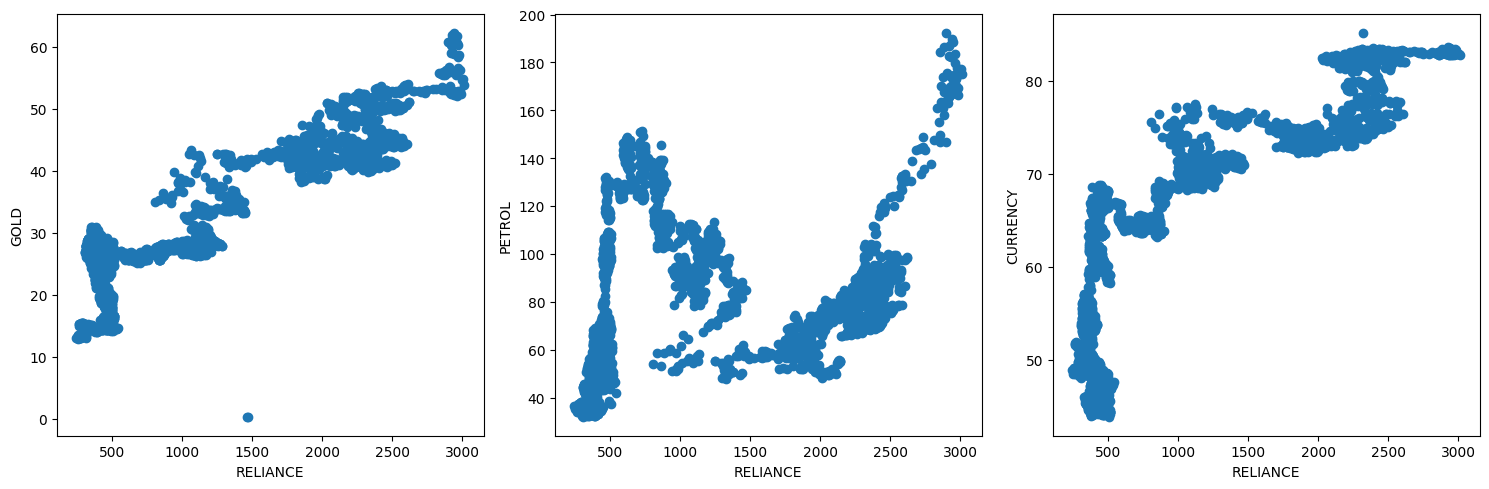

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, col in enumerate(['GOLD', 'PETROL', 'CURRENCY']):
    axs[i].scatter(data['RELIANCE'], data[col])
    axs[i].set_xlabel('RELIANCE')
    axs[i].set_ylabel(col)

plt.tight_layout()
plt.show()


# Linear Regression

c:\Users\shais\.conda\envs\tf\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Actual vs. Predicted Values:
            Actual RELIANCE  Predicted RELIANCE
Date                                           
2015-05-06       402.420685          585.583819
2021-03-02      1943.837280         1579.999288
2009-11-30       486.196411           47.949652
2021-02-01      1749.361328         1740.463665
2017-01-12       495.248322          886.864608
...                     ...                 ...
2013-01-30       411.175415          802.700662
2020-12-07      1807.417969         1763.230825
2019-07-03      1172.677368         1078.026466
2011-06-28       398.237610          305.781360
2021-03-03      2032.537598         1568.863224

[753 rows x 2 columns]

Mean Squared Error (MSE): 98551.77158239408
Root Mean Squared Error (RMSE): 313.9295646835355
Mean Absolute Error (MAE): 269.7239146406504


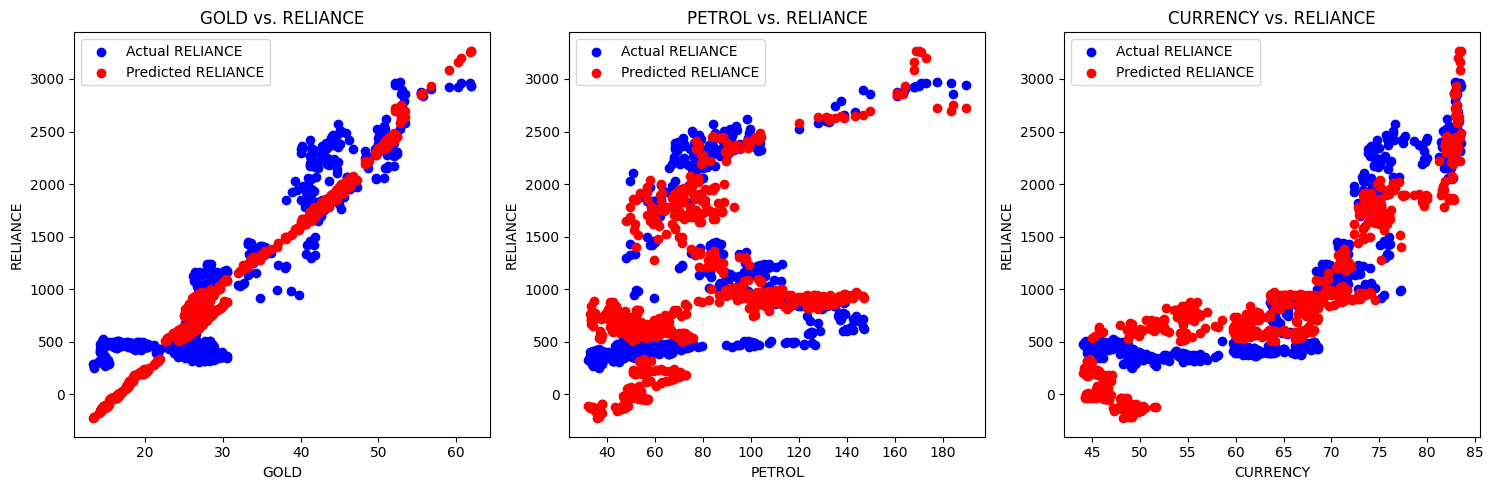

In [18]:
# Assuming data is your dataset
X = data[['GOLD', 'PETROL', 'CURRENCY']]
y = data['RELIANCE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

# Display actual and predicted values in a table
results_table = pd.DataFrame({
    'Actual RELIANCE': y_test,
    'Predicted RELIANCE': y_pred
})

print("Actual vs. Predicted Values:")
print(results_table)

# Display evaluation metrics
print(f'\nMean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')

# Plot scatter plots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

axes[0].scatter(X_test['GOLD'], y_test, color='blue', label='Actual RELIANCE')
axes[0].scatter(X_test['GOLD'], y_pred, color='red', label='Predicted RELIANCE')
axes[0].set_xlabel('GOLD')
axes[0].set_ylabel('RELIANCE')
axes[0].set_title('GOLD vs. RELIANCE')
axes[0].legend()

axes[1].scatter(X_test['PETROL'], y_test, color='blue', label='Actual RELIANCE')
axes[1].scatter(X_test['PETROL'], y_pred, color='red', label='Predicted RELIANCE')
axes[1].set_xlabel('PETROL')
axes[1].set_ylabel('RELIANCE')
axes[1].set_title('PETROL vs. RELIANCE')
axes[1].legend()

axes[2].scatter(X_test['CURRENCY'], y_test, color='blue', label='Actual RELIANCE')
axes[2].scatter(X_test['CURRENCY'], y_pred, color='red', label='Predicted RELIANCE')
axes[2].set_xlabel('CURRENCY')
axes[2].set_ylabel('RELIANCE')
axes[2].set_title('CURRENCY vs. RELIANCE')
axes[2].legend()

plt.tight_layout()
plt.show()


In [19]:
def calculate_metrics(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    return mse, rmse, r2

X = data[['GOLD', 'PETROL', 'CURRENCY']]
y = data['RELIANCE']

metrics_dict = {'GOLD': {}, 'PETROL': {}, 'CURRENCY': {}}

for feature in X.columns:
    current_feature = X[[feature]]

    X_train, X_test, y_train, y_test = train_test_split(current_feature, y, test_size=0.2, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mse, rmse, r2 = calculate_metrics(y_test, y_pred)

    metrics_dict[feature]['MSE'] = mse
    metrics_dict[feature]['RMSE'] = rmse
    metrics_dict[feature]['R-squared'] = r2

for feature, metrics in metrics_dict.items():
    print(f'Feature: {feature}')
    print(f'Mean Squared Error: {metrics["MSE"]}')
    print(f'Root Mean Squared Error: {metrics["RMSE"]}')
    print(f'R-squared: {metrics["R-squared"]}')
    print('-' * 30)


Feature: GOLD
Mean Squared Error: 104005.35689293288
Root Mean Squared Error: 322.49861533490787
R-squared: 0.8280940984302079
------------------------------
Feature: PETROL
Mean Squared Error: 474486.1158654949
Root Mean Squared Error: 688.8295259826591
R-squared: 0.2157426697340702
------------------------------
Feature: CURRENCY
Mean Squared Error: 202701.9517525626
Root Mean Squared Error: 450.22433491823006
R-squared: 0.6649628172339983
------------------------------


c:\Users\shais\.conda\envs\tf\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\shais\.conda\envs\tf\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\shais\.conda\envs\tf\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [20]:
def calculate_metrics(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    return mse, rmse, r2

X = data[['GOLD', 'PETROL', 'CURRENCY']]
y = data['RELIANCE']

metrics_dict = {'Feature': [], 'MSE': [], 'RMSE': [], 'R-squared': []}

for feature in X.columns:
    current_feature = X[[feature]]

    X_train, X_test, y_train, y_test = train_test_split(current_feature, y, test_size=0.2, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mse, rmse, r2 = calculate_metrics(y_test, y_pred)

    metrics_dict['Feature'].append(feature)
    metrics_dict['MSE'].append(mse)
    metrics_dict['RMSE'].append(rmse)
    metrics_dict['R-squared'].append(r2)

results_df = pd.DataFrame(metrics_dict)
print(results_df)


    Feature            MSE        RMSE  R-squared
0      GOLD  104005.356893  322.498615   0.828094
1    PETROL  474486.115865  688.829526   0.215743
2  CURRENCY  202701.951753  450.224335   0.664963


c:\Users\shais\.conda\envs\tf\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\shais\.conda\envs\tf\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\shais\.conda\envs\tf\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# Random Forest

In [21]:
def calculate_metrics(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    return mse, rmse, r2

X = data[['GOLD', 'PETROL', 'CURRENCY']]
y = data['RELIANCE']

metrics_dict_rf = {'Feature': [], 'MSE': [], 'RMSE': [], 'R-squared': []}

for feature in X.columns:
    current_feature = X[[feature]]

    X_train, X_test, y_train, y_test = train_test_split(current_feature, y, test_size=0.2, random_state=42)

    model_rf = RandomForestRegressor(random_state=42)
    model_rf.fit(X_train, y_train)

    y_pred_rf = model_rf.predict(X_test)

    mse_rf, rmse_rf, r2_rf = calculate_metrics(y_test, y_pred_rf)

    metrics_dict_rf['Feature'].append(feature)
    metrics_dict_rf['MSE'].append(mse_rf)
    metrics_dict_rf['RMSE'].append(rmse_rf)
    metrics_dict_rf['R-squared'].append(r2_rf)

results_df_rf = pd.DataFrame(metrics_dict_rf)
print(results_df_rf)


c:\Users\shais\.conda\envs\tf\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\shais\.conda\envs\tf\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


    Feature            MSE        RMSE  R-squared
0      GOLD   72537.309704  269.327514   0.880106
1    PETROL  439437.462477  662.900794   0.273673
2  CURRENCY   58263.642122  241.378628   0.903699


c:\Users\shais\.conda\envs\tf\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# KNN

In [22]:
def calculate_metrics(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    return mse, rmse, r2

X = data[['GOLD', 'PETROL', 'CURRENCY']]
y = data['RELIANCE']

metrics_dict_knn = {'Feature': [], 'MSE': [], 'RMSE': [], 'R-squared': []}

for feature in X.columns:
    current_feature = X[[feature]]

    X_train, X_test, y_train, y_test = train_test_split(current_feature, y, test_size=0.2, random_state=42)

    model_knn = KNeighborsRegressor(n_neighbors=5)
    model_knn.fit(X_train, y_train)

    y_pred_knn = model_knn.predict(X_test)

    mse_knn, rmse_knn, r2_knn = calculate_metrics(y_test, y_pred_knn)

    metrics_dict_knn['Feature'].append(feature)
    metrics_dict_knn['MSE'].append(mse_knn)
    metrics_dict_knn['RMSE'].append(rmse_knn)
    metrics_dict_knn['R-squared'].append(r2_knn)

results_df_knn = pd.DataFrame(metrics_dict_knn)
print(results_df_knn)


    Feature            MSE        RMSE  R-squared
0      GOLD   58645.068322  242.167439   0.903068
1    PETROL  358658.062342  598.880675   0.407190
2  CURRENCY   51351.093533  226.607797   0.915124


c:\Users\shais\.conda\envs\tf\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\shais\.conda\envs\tf\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\shais\.conda\envs\tf\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# ANN

In [23]:
def calculate_metrics(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    return mse, rmse, r2

# Assuming data is your dataset
X = data[['GOLD', 'PETROL', 'CURRENCY']]
y = data['RELIANCE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model_ann = Sequential()
model_ann.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
model_ann.add(Dense(16, activation='relu'))
model_ann.add(Dense(1, activation='linear'))

model_ann.compile(optimizer='adam', loss='mean_squared_error')

model_ann.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=0)

y_pred_ann = model_ann.predict(X_test_scaled).flatten()

mse_ann, rmse_ann, r2_ann = calculate_metrics(y_test, y_pred_ann)

# Create a DataFrame to display actual and predicted prices
results_ann = pd.DataFrame({'Actual Prices': y_test, 'Predicted Prices (ANN)': y_pred_ann})

# Display the DataFrame and metrics
print("Actual and Predicted Prices (ANN):")
print(results_ann.head())

print("\nPerformance Metrics (ANN):")
print(f'Mean Squared Error (ANN): {mse_ann}')
print(f'Root Mean Squared Error (ANN): {rmse_ann}')
print(f'R-squared (ANN): {r2_ann}')


c:\Users\shais\.conda\envs\tf\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Actual and Predicted Prices (ANN):
            Actual Prices  Predicted Prices (ANN)
Date                                             
2015-05-06     402.420685              406.268219
2021-03-02    1943.837280             1593.120728
2009-11-30     486.196411              445.382172
2021-02-01    1749.361328             1714.657593
2017-01-12     495.248322              817.362183

Performance Metrics (ANN):
Mean Squared Error (ANN): 35558.970924842986
Root Mean Squared Error (ANN): 188.57086446437845
R-squared (ANN): 0.94122613355366


c:\Users\shais\.conda\envs\tf\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# LSTM

Epoch 1/50


c:\Users\shais\.conda\envs\tf\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0055 - val_loss: 0.0017
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.3269e-05 - val_loss: 0.0033
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.5462e-05 - val_loss: 0.0011
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.8787e-05 - val_loss: 6.6336e-04
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.1396e-05 - val_loss: 6.0507e-04
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.8570e-05 - val_loss: 6.1456e-04
Epoch 7/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.6512e-05 - val_loss: 5.7647e-04
Epoch 8/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.4755e-05 - val_loss: 6.2841e-04
Epoch 9/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.5028e-05 - val_loss: 0.0011
Epoch 10/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.0988e-05 - val_loss: 6.2639e-04
Epoch 11/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.7693e-05 - val_loss: 9.7231e-04
Epoch 12/50
83/83

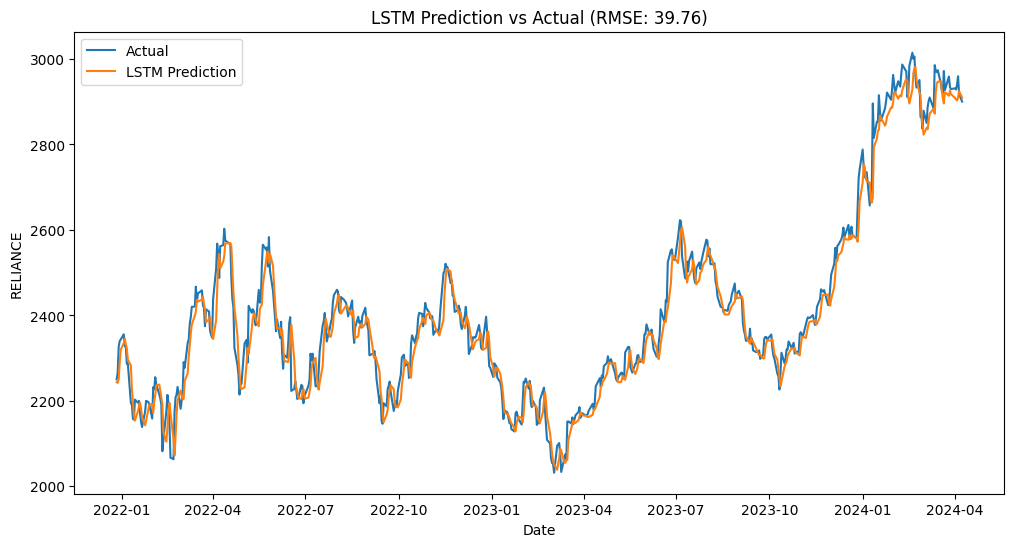

Root Mean Squared Error (RMSE): 39.76
Error Percentage: 1.65%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Forecasted stock prices for the upcoming 7 days:
2024-04-25: 2243.424072265625
2024-04-26: 2241.98974609375
2024-04-27: 2250.760009765625
2024-04-28: 2289.600830078125
2024-04-29: 2319.682373046875
2024-04-30: 2334.97216796875


In [24]:
target_variable = 'RELIANCE'
y = data[target_variable].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler.fit_transform(y)

def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target = data[i+seq_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

sequence_length = 10

X_seq, y_seq = create_sequences(y_scaled, sequence_length)

train_size = int(len(X_seq) * 0.7)
val_size = int(len(X_seq) * 0.15)
test_size = len(X_seq) - train_size - val_size

X_train, y_train = X_seq[:train_size], y_seq[:train_size]
X_val, y_val = X_seq[train_size:train_size+val_size], y_seq[train_size:train_size+val_size]
X_test, y_test = X_seq[train_size+val_size:], y_seq[train_size+val_size:]

model_lstm = Sequential()
model_lstm.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=1)

y_pred_lstm = model_lstm.predict(X_test)

y_pred_lstm_inv = scaler.inverse_transform(y_pred_lstm)
y_test_inv = scaler.inverse_transform(y_test)

rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, y_pred_lstm_inv))

test_dates = data.index[train_size+val_size : train_size+val_size+len(y_test_inv)]

plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_inv, label='Actual')
plt.plot(test_dates, y_pred_lstm_inv, label='LSTM Prediction')
plt.title(f'LSTM Prediction vs Actual (RMSE: {rmse_lstm:.2f})')
plt.xlabel('Date')  # Update xlabel to 'Date'
plt.ylabel(target_variable)
plt.legend()
plt.show()

error_percentage = (rmse_lstm / np.mean(y_test_inv)) * 100

print(f'Root Mean Squared Error (RMSE): {rmse_lstm:.2f}')
print(f'Error Percentage: {error_percentage:.2f}%')

forecasted_values_scaled = []
for i in range(7):
    X_new = np.array([X_test[i]])
    forecasted_value_scaled = model_lstm.predict(X_new)[0][0]
    forecasted_values_scaled.append(forecasted_value_scaled)
    X_test = np.concatenate((X_test, X_new), axis=0)

forecasted_values = scaler.inverse_transform(np.array(forecasted_values_scaled).reshape(-1, 1))
forecasted_dates = pd.date_range(data.index[-1], periods=7, freq='D')[1:]

print("Forecasted stock prices for the upcoming 7 days:")
for date, price in zip(forecasted_dates, forecasted_values):
    print(f"{date.strftime('%Y-%m-%d')}: {price[0]}")




# All models together

In [25]:
def calculate_metrics(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    return mse, rmse, mae

X = data[['GOLD', 'PETROL', 'CURRENCY']]
y = data['RELIANCE']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=40)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

scaler_ann = StandardScaler()
X_train_scaled_ann = scaler_ann.fit_transform(X_train)
X_test_scaled_ann = scaler_ann.transform(X_test)
X_val_scaled_ann = scaler_ann.transform(X_val)

scaler_lstm = MinMaxScaler(feature_range=(0, 1))
y_train_scaled_lstm = scaler_lstm.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled_lstm = scaler_lstm.transform(y_test.values.reshape(-1, 1))

model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)
mse_lr, rmse_lr, mae_lr = calculate_metrics(y_test, y_pred_lr)
error_percentage_lr = (mae_lr / y_test.mean()) * 100

model_rf = RandomForestRegressor(random_state=42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)
mse_rf, rmse_rf, mae_rf = calculate_metrics(y_test, y_pred_rf)
error_percentage_rf = (mae_rf / y_test.mean()) * 100

metrics_dict_knn = {'Feature': [], 'MSE': [], 'RMSE': [], 'MAE': []}
for feature in X.columns:
    current_feature = X_train[[feature]]
    model_knn = KNeighborsRegressor(n_neighbors=5)
    model_knn.fit(current_feature, y_train)
    current_feature_test = X_test[[feature]]
    y_pred_knn = model_knn.predict(current_feature_test)
    mse_knn, rmse_knn, mae_knn = calculate_metrics(y_test, y_pred_knn)
    metrics_dict_knn['Feature'].append(feature)
    metrics_dict_knn['MSE'].append(mse_knn)
    metrics_dict_knn['RMSE'].append(rmse_knn)
    metrics_dict_knn['MAE'].append(mae_knn)

metrics_df_knn = pd.DataFrame(metrics_dict_knn)
error_percentage_knn = (metrics_df_knn['MAE'].mean() / y_test.mean()) * 100

model_ann = Sequential()
model_ann.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
model_ann.add(Dense(16, activation='relu'))
model_ann.add(Dense(1, activation='linear'))
model_ann.compile(optimizer='adam', loss='mean_squared_error')
model_ann.fit(X_train_scaled_ann, y_train, epochs=50, batch_size=32, verbose=0)
y_pred_ann = model_ann.predict(X_test_scaled_ann).flatten()
mse_ann, rmse_ann, mae_ann = calculate_metrics(y_test, y_pred_ann)
error_percentage_ann = (mae_ann / y_test.mean()) * 100

sequence_length_lstm = 10
X_seq_lstm, y_seq_lstm = create_sequences(y_train_scaled_lstm, sequence_length_lstm)

X_seq_val_lstm, y_seq_val_lstm = create_sequences(scaler_lstm.transform(y_val.values.reshape(-1, 1)), sequence_length_lstm)
X_seq_test_lstm, y_seq_test_lstm = create_sequences(y_test_scaled_lstm, sequence_length_lstm)

model_lstm = Sequential()
model_lstm.add(LSTM(50, input_shape=(X_seq_lstm.shape[1], X_seq_lstm.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_seq_lstm, y_seq_lstm, epochs=50, batch_size=32, validation_data=(X_seq_val_lstm, y_seq_val_lstm), verbose=0)
y_pred_lstm = model_lstm.predict(X_seq_test_lstm)
y_pred_lstm_inv = scaler_lstm.inverse_transform(y_pred_lstm.reshape(-1, 1)).flatten()
y_test_inv_lstm = scaler_lstm.inverse_transform(y_seq_test_lstm.reshape(-1, 1)).flatten()
rmse_lstm = np.sqrt(mean_squared_error(y_test_inv_lstm, y_pred_lstm_inv))

results_lr = pd.DataFrame({'Actual': y_test, 'Predicted_LR': y_pred_lr})
results_rf = pd.DataFrame({'Actual': y_test, 'Predicted_RF': y_pred_rf})
results_knn = pd.DataFrame({'Actual': y_test, 'Predicted_KNN': y_pred_knn})
results_ann = pd.DataFrame({'Actual': y_test, 'Predicted_ANN': y_pred_ann})
results_lstm = pd.DataFrame({'Actual': y_test_inv_lstm, 'Predicted_LSTM': y_pred_lstm_inv})

error_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'k-Nearest Neighbors', 'Artificial Neural Network', 'LSTM'],
    'MSE': [mse_lr, mse_rf, metrics_df_knn['MSE'].mean(), mse_ann, mean_squared_error(y_test_inv_lstm, y_pred_lstm_inv)],
    'RMSE': [rmse_lr, rmse_rf, metrics_df_knn['RMSE'].mean(), rmse_ann, rmse_lstm],
    'MAE': [mae_lr, mae_rf, metrics_df_knn['MAE'].mean(), mae_ann, mean_absolute_error(y_test_inv_lstm, y_pred_lstm_inv)],
    'Error Percentage': [error_percentage_lr, error_percentage_rf, error_percentage_knn, error_percentage_ann, (mean_absolute_error(y_test_inv_lstm, y_pred_lstm_inv) / y_test_inv_lstm.mean()) * 100]
})

print("Results for Linear Regression:")
print(results_lr.head())
print("\nResults for Random Forest:")
print(results_rf.head())
print("\nResults for k-Nearest Neighbors:")
print(results_knn.head())
print("\nResults for Artificial Neural Network:")
print(results_ann.head())
print("\nResults for LSTM:")
print(results_lstm.head())

print("\nError Table:")
print(error_df)

error_df.to_csv('regression_results.csv', index=False)


c:\Users\shais\.conda\envs\tf\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\shais\.conda\envs\tf\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\shais\.conda\envs\tf\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\shais\.conda\envs\tf\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squ

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


c:\Users\shais\.conda\envs\tf\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\shais\.conda\envs\tf\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Results for Linear Regression:
                 Actual  Predicted_LR
Date                                 
2010-02-15   461.738007     -6.182034
2022-06-30  2395.784180   1872.381787
2020-04-01   987.890808   1464.196589
2012-04-02   338.554535    661.741693
2019-04-05  1237.915039    953.786879

Results for Random Forest:
                 Actual  Predicted_RF
Date                                 
2010-02-15   461.738007    470.440296
2022-06-30  2395.784180   2300.142847
2020-04-01   987.890808    980.236898
2012-04-02   338.554535    335.435074
2019-04-05  1237.915039   1252.387147

Results for k-Nearest Neighbors:
                 Actual  Predicted_KNN
Date                                  
2010-02-15   461.738007     472.264276
2022-06-30  2395.784180    2282.956592
2020-04-01   987.890808    1815.055103
2012-04-02   338.554535     346.020068
2019-04-05  1237.915039    1165.463354

Results for Artificial Neural Network:
                 Actual

# SENTIMENT ANALYSIS

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\shais\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
C:\Users\shais\AppData\Local\Temp\ipykernel_19276\3822301558.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Headline'].fillna('', inplace=True)
C:\Users\shais\AppData\Local\Temp\ipykernel_19276\3822301558.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior w

╒══════════╤═══════════╤════════════════════╕
│ Metric   │     Error │   Error Percentage │
╞══════════╪═══════════╪════════════════════╡
│ MSE      │ 23538.8   │          3674.5    │
├──────────┼───────────┼────────────────────┤
│ RMSE     │   153.424 │            23.95   │
├──────────┼───────────┼────────────────────┤
│ MAE      │   119.168 │            18.6026 │
╘══════════╧═══════════╧════════════════════╛


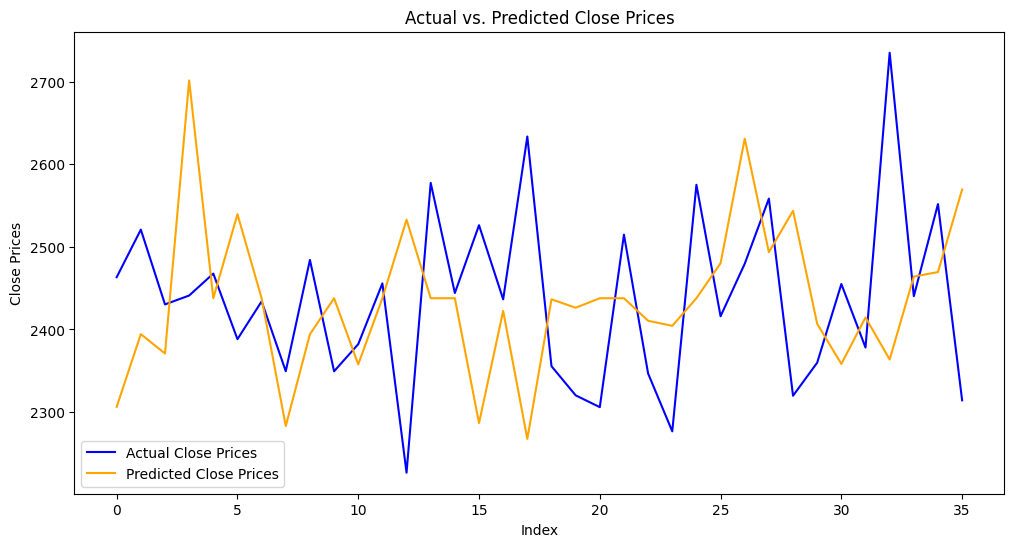

In [26]:
nltk.download('vader_lexicon')

df = pd.read_csv('sentiment.csv')
df['Headline'].fillna('', inplace=True)
df['Content'].fillna('', inplace=True)

sid = SentimentIntensityAnalyzer()
df['Headline_Sentiment'] = df['Headline'].apply(lambda x: sid.polarity_scores(str(x))['compound'])
df['Content_Sentiment'] = df['Content'].apply(lambda x: sid.polarity_scores(str(x))['compound'])

df.to_csv('sentiment_with_scores.csv', index=False)

X = df[['Headline_Sentiment', 'Content_Sentiment']]
y = df['Close']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

model = RandomForestRegressor()
model.fit(X_train, y_train)

test_preds = model.predict(X_test)

y_test = y_test.reset_index(drop=True)
test_preds = pd.Series(test_preds, name='Predicted')

mse_test = mean_squared_error(y_test, test_preds)
rmse_test = sqrt(mse_test)
mae_test = mean_absolute_error(y_test, test_preds)

range_close = y.max() - y.min()
mse_percentage = (mse_test / range_close) * 100
rmse_percentage = (rmse_test / range_close) * 100
mae_percentage = (mae_test / range_close) * 100

table = [['Metric', 'Error', 'Error Percentage'],
         ['MSE', mse_test, mse_percentage],
         ['RMSE', rmse_test, rmse_percentage],
         ['MAE', mae_test, mae_percentage]]

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Close Prices', color='blue')
plt.plot(y_test.index, test_preds, label='Predicted Close Prices', color='orange')
plt.xlabel('Index')
plt.ylabel('Close Prices')
plt.title('Actual vs. Predicted Close Prices')
plt.legend()

plt.show()
